# IBM Data Science Capstone Project- Online Food Catering Service in Toronto

This project is the final capstone project for the IBM Data Science Specialization course offered by Coursera. It utilizes the available Toronto neighborhood statistics, and the independent business location and review data to make a recommendation for a new online food catering service that would target university students and young professionals in the high-density residential neighborhoods in downtown Toronto. 


### Table of Contents:  

   1. <b> Introduction Section    </b>
   2. <b> Data Section   </b>
   3. <b> Methodology Section   </b>
   4. <b> Result Section   </b>
   5. <b> Discussion Section   </b>
   6. <b> Conclusion Section    </b> 
 

## 1. Introduction Section

Introduction where you discuss the business problem and who would be interested in this project.

### 1.1 Background and Scenario

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 3 million. Toronto is also the hub the Greater Toronto Area with an urban agglomeration of over 6 million population within a 50-kilometre radius. Downtown Toronto is the heart of financial, commercial and education businesses, and over half a million young university students and professionals living in the high-density neighborhoods occupied with high-rise condos and apartments. 

Given the recent rise of Uber Eat and the research that more and more young single dewellers in the urban rely on online service and social media for foods, there is a huge business opportunity for online food catering service that target the young students and professionals.

### 1.2 Problem to be resolved

The studied business problem is to make a recommendation for a online food catering service that would target the young professionals and university students who live in the high-density downtown neighborhoods and tend to rely on online services and social media for food choices.   
Therefore, in order to resolve the problem, the following aspects would be explored and researched to form a comparison basis among the listed neighborhoods and recommend the best location:

<ul>
    <li> <b> Geocoding: </b> Identify and map out the neighborhoods in downtown Toronto</li>
    <li> <b> Business: </b> Summarize the current status of the restaurants and food catering services in each neighborhood</li>
    <li> <b> Competition: </b> Evaluation the density and average review for "Asian Food" as a gauge for business competition</li>
    <li> <b> Clustering: </b> Using Machine Learning Algorithm to cluster and rank the neighborhoods for the best candidate for the proposed online food catering service</li>
    
</ul>    

### 1.3 Interested audience

This project would provide valued-added propositions not only for the entrepreneurs who are planning to open a business in downtown Toronto, but also to the online service providers like Uber Eat and Mei Tuan. In addition, the potential audience can be like the social media service provider like Facebook, Tweets and Yelp etc.   




## 2. Data Section

 Describe the data that will be used to solve the problem and the source of the data

### 2.1 Toronto neighborhood data - downtown location

For administrative purposes, the City of Toronto divides the city into 140 neighbourhoods. These divisions are used for internal planning purposes. The boundaries and names often do not conform to the usage of the general population or designated business improvement areas. A number of neighbourhood maps of Toronto do exist, some produced by real estate firms and some by Internet portals. A project to map the neighbourhoods according to the common usage of the residents was done by the Toronto Star broadsheet newspaper. Based on feedback from Star readers, it has produced a comprehensive, albeit informal, neighbourhood map.

In this project, the focus is on Downtown core (Central Toronto). The data is available online through Wikipedia.

As mentioned in the Neighborhood Clustering and Segment assignment in this course, I used BeautifulSoup to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, The data is then filtered and transformed into pandas DataFrame for further analysis. Below is an excerpt of the Toronto neighborhood file:
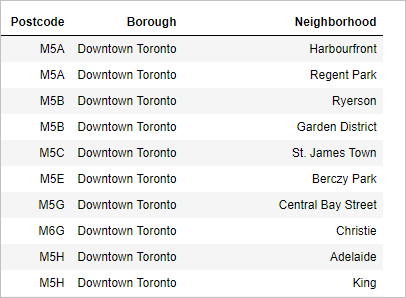

### 2.2 Mapping data - visualization

In order to map the Toronto neighborhoods to other data files like business location and folium map, I used the online geographical data ('http://cocl.us/Geospatial_data') that provides the latitude and longitude based on the location's post code. Eventually, the corresponding latitude and longitude will be merged to the above Toronto neighborhood data. Below is a sample: 
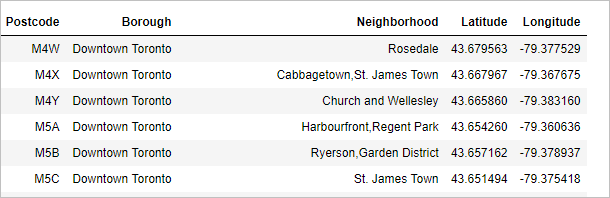

In addition, Python folium library  is used to map the neighborhoods and display them on the map.

### 2.3 Restaurant venue and rating data - downtown location

To evaluate the business competition, I used Foursquare to generate a restaurant list based on the category, and further filtered it to include only "Asian Food" restaurants and food catering services. In addition, the review tips are summarized and used as one of the key features for neighborhood clustering and segmentation.

### 2.4 How the data is used to solve the problem

The data will be used as follows:  
<ul>
    <li> Scrape Toronto neighborhood data and convert it into pandas dataframe. In addition, using a filtration to include only the neighborhoods in downtown Toronto Core; </li>
    <li> Download the geocoding data file and attach "latitude" and "longitude" for each neighborhood and business location based on the post code;</li>
    <li>Use Foursquare and geopy python library to generate the business venues and review tips within each neighborhood. Furthermore, summarize the business presence and average review score as the key business competition measures;</li>
    <li> Use the combination of the above preprocessed data and K-means algorithm to further cluster and segment the neighborhoods, profile and rank each neighborhood and eventually make a recommendation for the best candidate location for the proposed online food catering service.</li>
        
</ul>        

## 3. Methodology section

This section represents the main component of the report to discuss and describe the exploratory data analysis (data acquisition, preprocessing and analysis), business competitiveness analysis and using k-means clustering machine learnings algorithm to segment and rank the neighborhoods for the best location candidate.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import wget

###  3-1 Acquire Toronto neighborhood data through web scraping

In [2]:
# Scrape the Toronto neighborhood data from Wikipedia website
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wp=requests.get(url).text
wp_scrape=BeautifulSoup(wp, 'lxml')

In [3]:
col_name=['Postcode','Borough','Neighborhood']
wp_df=pd.DataFrame(columns=col_name)
wp_df

,Postcode,Borough,Neighborhood


In [4]:
wp_table=wp_scrape.find('table', class_="wikitable sortable")

for tr in wp_table.find_all('tr'):
    i=0
    tx=['','','']
    for td in tr.find_all('td'):
        tx[i]=td.text
        #print(i, tx[i])
        i=i+1
    #print(tx[0], tx[1], tx[2])
    wp_df=wp_df.append({'Postcode':tx[0],'Borough':tx[1], 'Neighborhood': tx[2].rstrip('\n')}, ignore_index=True)
print("DataFrame's shape:", wp_df.shape)
wp_df.head(10)

DataFrame's shape: (289, 3)


,Postcode,Borough,Neighborhood
0,,,
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Not assigned


#### Data preprocessing - filtration to include only downtown core neighborhoods in Toronto

In [5]:
# if "neighborhood" is not assigned, then assign the "borough" to it
for index, row in wp_df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']
wp_df=wp_df[( wp_df['Borough']!='Not assigned') & (wp_df['Borough']!="" )]
wp_df['Borough'].value_counts() 

Etobicoke           45
North York          38
Scarborough         37
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

In [6]:
# filtration: only include "Downtown Toronto" and "Queen's Park"
core_TO = wp_df[wp_df['Borough'].isin(['Downtown Toronto', 'Queen\'s Park'])]
print("The shape of Core_TO is:", core_TO.shape)
core_TO

The shape of Core_TO is: (38, 3)


,Postcode,Borough,Neighborhood
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
9,M7A,Queen's Park,Queen's Park
18,M5B,Downtown Toronto,Ryerson
19,M5B,Downtown Toronto,Garden District
35,M5C,Downtown Toronto,St. James Town
49,M5E,Downtown Toronto,Berczy Park
58,M5G,Downtown Toronto,Central Bay Street
59,M6G,Downtown Toronto,Christie
69,M5H,Downtown Toronto,Adelaide


### 3.2 Geocoding: attach latitude and longitude to each neighborhood

In [7]:
import wget
   
wget.download('http://cocl.us/Geospatial_data', 'tor_fsa_lng_lat.csv')
print('Data downloaded!')


100% [................................................................................] 2891 / 2891Data downloaded!


In [8]:
tor_ll=pd.read_csv('tor_fsa_lng_lat.csv')
tor_ll.columns=['Postcode', 'Latitude', 'Longitude']
tor_ll.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Attach latitude and longitude to each neighborhoo

In [9]:
core_TO_geo=pd.merge(core_TO, tor_ll, on='Postcode')
print("The shape of Core_TO_geo is:", core_TO_geo.shape)
core_TO_geo.head()

The shape of Core_TO_geo is: (38, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
3,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
4,M5B,Downtown Toronto,Garden District,43.657162,-79.378937


### 3-3 Exploratory Data Analysis

####  Retrieve the Lat and Long for Toronto

In [10]:
address='Toronto, ON'
geolocator=Nominatim(user_agent="Toronto_Explorer")
tor_loc=geolocator.geocode(address)
tor_long=tor_loc.longitude
tor_lat=tor_loc.latitude
print("Toronto Geo Coordinate are: Latitude is {}, and Longitude is {}".format(tor_lat, tor_long))

Toronto Geo Coordinate are: Latitude is 43.653963, and Longitude is -79.387207


####  Show the neighborhoods in core downtown Toronto on the map

In [11]:
map_toronto=folium.Map(location=[tor_lat, tor_long], zoom_start=14)

for lat, lng, borough, ngbr, in zip(core_TO_geo['Latitude'],core_TO_geo['Longitude'],core_TO_geo['Borough'],core_TO_geo['Neighborhood']):
    label='{}, {}'.format(borough, ngbr)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

###  3-4 Analyze Downtown Toronto's food catering business through Foursquare

#### Get the top 100 venues that are within a radius of 500 meters for each neighborhood

In [12]:
Limit=100
radius=500

CLIENT_ID = 'W4C2R2D0TMSFJDDSI2QUQDXOH4AFF1GC1J1PLYIUSMOMTGG0' # your Foursquare ID
CLIENT_SECRET = 'WBDIERVYDWFTIAYYETE4QSFZGFDAAJ242SDYX3PTBLJDT5IH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [13]:
core_TO_bus=core_TO_geo[core_TO_geo['Neighborhood']!= 'King']
core_TO_venues = getNearbyVenues(names=core_TO_bus['Neighborhood'],
                                   latitudes=core_TO_geo['Latitude'],
                                   longitudes=core_TO_geo['Longitude']
                                  )

Harbourfront
Regent Park
Queen's Park
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


In [14]:
print("The dimension of the DF is:",core_TO_venues.shape)
core_TO_venues.head(5)

The dimension of the DF is: (2464, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


####  Flatten the DF using onehot coding

In [15]:
# one hot encoding
core_TO_venues_flat = pd.get_dummies(core_TO_venues[['Venue Category']], prefix="", prefix_sep="")

# Filtration - only includes the "Restraunt" venue categories as features
restaurant_TO=core_TO_venues_flat.iloc[:,core_TO_venues_flat.columns.str.contains('Restaurant')]
restaurant_TO.columns.values


array(['American Restaurant', 'Asian Restaurant', 'Belgian Restaurant',
       'Brazilian Restaurant', 'Caribbean Restaurant',
       'Chinese Restaurant', 'Colombian Restaurant',
       'Comfort Food Restaurant', 'Dim Sum Restaurant',
       'Doner Restaurant', 'Dumpling Restaurant',
       'Eastern European Restaurant', 'Ethiopian Restaurant',
       'Falafel Restaurant', 'Fast Food Restaurant',
       'Filipino Restaurant', 'French Restaurant',
       'Gluten-free Restaurant', 'Greek Restaurant', 'Hotpot Restaurant',
       'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant',
       'Korean Restaurant', 'Latin American Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'Modern European Restaurant',
       'Molecular Gastronomy Restaurant', 'New American Restaurant',
       'Persian Restaurant', 'Portuguese Restaurant', 'Ramen Restaurant',
       'Restaurant', 'Seafood Restaurant', 'Sushi Restaurant',
       'Taiwane

#### Summarizing
(1) Target restaurant: Asian retaurants, including ['Asian Restaurant','Chinese Restaurant','Dim Sum Restaurant',
                   'Japanese Restaurant','Korean Restaurant','Ramen Restaurant','Sushi Restaurant','Dumpling Restaurant',
                   'Taiwanese Restaurant', 'Thai Restaurant','Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant']  
(2) Summarization: calculate and rank by the total number of the target restaurants 
(3) Create a new dataframe with neighborhood, restaurant ranking and restaurant details

In [19]:
# (1) Filtration to include only the interested target restaurants:
target_restaurant=['Asian Restaurant','Chinese Restaurant','Dim Sum Restaurant','Dumpling Restaurant',
                   'Japanese Restaurant','Korean Restaurant','Ramen Restaurant','Sushi Restaurant',
                   'Taiwanese Restaurant', 'Thai Restaurant','Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant']

# (2) Adding a total column
restaurant_TO2=restaurant_TO[target_restaurant]
restaurant_TO2.loc[:,'Total']=restaurant_TO[target_restaurant].sum(axis=1)
restaurant_TO2=pd.concat([restaurant_TO[target_restaurant], total], axis=1)

# (3) concatenating the onehot code back to the original DF
core_TO_df=pd.concat([core_TO_venues, restaurant_TO2], axis=1)

# (4) aggregating by 'neighborhood'
core_TO_agg=core_TO_df.groupby("Neighborhood").sum().reset_index()


# (5) ranking by the restaurant count
core_TO_agg.sort_values('Total', ascending=False, inplace=True)



In [20]:
# (6) displaying the sorted neighborhoods
core_TO_agg

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Asian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Japanese Restaurant,Korean Restaurant,Ramen Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
3,CN Tower,4365.320570,-7940.004930,4365.420872,-7940.077103,0,4,1,4,1,0,1,0,0,1,6,4,22
19,Kensington Market,4365.320570,-7940.004930,4365.420872,-7940.077103,0,4,1,4,1,0,1,0,0,1,6,4,22
13,Grange Park,4365.320570,-7940.004930,4365.420872,-7940.077103,0,4,1,4,1,0,1,0,0,1,6,4,22
0,Adelaide,4365.057120,-7938.456750,4364.988214,-7938.411657,2,0,0,0,1,0,0,2,0,3,2,0,10
5,Central Bay Street,3754.583906,-6827.314904,3754.585881,-6827.184893,0,2,0,0,2,1,1,2,0,1,1,0,10
24,Richmond,4365.057120,-7938.456750,4364.988214,-7938.411657,2,0,0,0,1,0,0,2,0,3,2,0,10
16,Harbourfront East,4365.057120,-7938.456750,4364.988214,-7938.411657,2,0,0,0,1,0,0,2,0,3,2,0,10
12,Garden District,4365.716180,-7937.893710,4365.614565,-7938.041942,0,1,0,0,2,0,2,0,0,1,1,1,8
32,Underground city,4364.842920,-7938.228020,4364.882213,-7938.235630,3,0,0,0,2,0,0,0,0,2,1,0,8
28,St. James Town,6286.539938,-11429.719503,6286.326238,-11429.789930,0,1,0,0,3,0,0,0,1,2,1,0,8


## 4. Result and Discussion section

Out goal is to **identify a candidate neighborhood** in Downtown Toronto for setting up **an online food catering service specialized in Asian/Chinese cuisine**.   

The ***Business Requirements*** for the candidate location are:   
1) Location: located in core downtown Toronto;   
2) Business Competition: low Asian/Chinese restaurant density in the target neighborhood;   
3) Demographic Presence: high population density and diversified culture.  

Based on the above analysis, we have “Resedale” and “Regent Park” the 2 final candidates for the proposed location: both have low presence of Asian/Chinese restaurant and located in core downtown Toronto. Through further research on demographic profile, we have the following summaries:

#### 1)	Regent Park 
It is a neighbourhood located in downtown Toronto, built in the late 1940s as a public housing project, including all of the 69 acres (280,000 m²) which comprise the community. The neighbourhood's ethnic composition has changed between 2001 and 2016. By the 2016 census, Europeans had become the largest group, while the presence of visible minority groups declined. The neighbourhood in 2016 was 28% European, 25.7% South Asian, 13.6% Black, 12.5% Chinese and 3.7% Southeast Asian.  In Regent Park, the median household income in 2016 was $42,369, lower than the median household income 65,826 in Toronto. As well, the Regent Park neighbourhood has a higher percentage of households without income (5.9%) compared to the City of Toronto average (4.7%), and 44.4% of households are at or below the poverty level, compared to 20.2% for the city average. 

#### 2) Rosedale
It is located north of Downtown Toronto and is one of its oldest suburbs. It is also one of the wealthiest and most highly priced neighbourhoods in Canada. According to Census tracts 0086.00 and 0087.00 of the 2006 Canadian census, Rosedale has 7,672 residents, up 4.8% from the 2001 census. The median income in this Census Tract in the 2006 Canadian Census was $55,906, while the average total income in this Census was $165,827, one of the highest incomes of all Toronto neighbourhoods. The median income level was also double that of Canada and Ontario, while the average total income levels were 4.5 to 5 times larger than that of Ontario and Canada. Similarly, the total income levels reflected in the 2011 National Household Survey (NHS) were exceedingly high with the total income median at $61,284, more than double that of Ontario and Canada, and the total income average at $210,484, more than 5 times that of Ontario and Canada.[18] In 2015 the average Rosedale house sold for over $1,800,000.[19] Additionally, Rosedale possesses a large population of people of English, Scottish, and Irish ethnic origin 

It’s interesting to see how the above two are ranked closely in the above analysis: both are highly populated, less Asian/Chinese restaurant density, and located in the core downtown (i.e. satisfied the first 2 business requirements), but have a quite contrasting demographic profiles. **Regent Park** is mainly the social housing neighborhoods with below average income and diversified culture; while on the contrast, **Rosedale** is an affluent and established neighborhoods and possesses a large population of English, Scottish and Irish ethnic origin.
As the proposed business is an online food catering service targeting for people who want to have less-expense fast food delivery through Uber Eat ®, so, the conclusion is “Regent Park” is clear a better choice and satisfy all the three listed business requirements. 



## 5. Conclusion section

The **objective** of this project is to leverage the available data (geographic, business presence, demographic data) and data analysis techniques to best propose a candidate location in core downtown Toronto for an online food catering services specialized in Asian/Chinese cuisine. The **three business requirements** are: Location, Business competitiveness and neighborhood’s demographic profile ( see Results and Discussion section for details ). 

Though the analysis, Regent Park is a clear good choice for the proposed business:
1)	It’s located in core downtown Toronto, and it’s close to other highly-populated neighborhoods including the university/college residence;
2)	Currently, the restaurant density for Asian/Chinese cuisine is low, compared to other neighborhoods;
3)	The neighborhood possess a large dwellings with below average household income and multi-culture background, a good market for less-expensive fast food delivery business. 
